# Setup

In [1]:
import numpy as np
import pandas as pd
import json, os
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Data Fetching

In [2]:
!git clone https://github.com/allenai/PeerRead.git

Cloning into 'PeerRead'...
remote: Enumerating objects: 27026, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 27026 (delta 0), reused 0 (delta 0), pack-reused 27023
Receiving objects: 100% (27026/27026), 1.15 GiB | 22.14 MiB/s, done.
Resolving deltas: 100% (1466/1466), done.
Checking out files: 100% (25772/25772), done.


# Data Processing

In [2]:
def get_all_json(path):
  dev_parsed = {}
  dev_reviews = {}
  test_parsed = {}
  test_reviews = {}
  train_parsed = {}
  train_reviews = {}
  for subdir, dirs, files in os.walk(path):
    for f in files:
      path_name = os.path.join(subdir, f)
      id = '.'.join([part for part in path_name.split('/')[-1].split('.') if part.isnumeric()])
      if path_name.endswith('.pdf.json'):
        if 'dev' in path_name:
          dev_parsed[id] = json.load(open(path_name, 'r'))
        elif 'test' in path_name:
          test_parsed[id] = json.load(open(path_name, 'r'))
        elif 'train' in path_name:
          train_parsed[id] = json.load(open(path_name, 'r'))
      elif path_name.endswith('.json'):
        if 'dev' in path_name:
          dev_reviews[id] = json.load(open(path_name, 'r'))
        elif 'test' in path_name:
          test_reviews[id] = json.load(open(path_name, 'r'))
        elif 'train' in path_name:
          train_reviews[id] = json.load(open(path_name, 'r'))
  return dev_parsed, dev_reviews, test_parsed, test_reviews, train_parsed, train_reviews

acl_data = get_all_json('PeerRead/data/acl_2017')
cs_ai_data = get_all_json('PeerRead/data/arxiv.cs.ai_2007-2017')
cs_cl_data = get_all_json('PeerRead/data/arxiv.cs.cl_2007-2017')
cs_lg_data = get_all_json('PeerRead/data/arxiv.cs.lg_2007-2017')
conll_data = get_all_json('PeerRead/data/conll_2016')
iclr_data = get_all_json('PeerRead/data/iclr_2017')
nips_data = get_all_json('PeerRead/data/nips_2013-2017')

# Creating the DataFrames

In [37]:
def create_dataframe(json_data, json_reviews, dataset_name=''):
  modified_arr = []
  for id in json_data.keys():
    fields = {'id': id}
    # fields of metadata are 'source', 'title', 'authors', 'emails', 'sections', 'references', 'referenceMentions', 'year', 'abstractText', 'creator'
    # fields of review_data are 'reviews', 'abstract', 'histories', 'id', 'title'
    metadata = json_data[id]['metadata']
    review_data = json_reviews[id]
    fields['titleLen'] = len(review_data['title'])
    authors = []
    if 'authors' in review_data.keys() and len(review_data['authors']) > 0:
      authors = review_data['authors']
    elif 'authors' in metadata.keys() and len(metadata['authors']) > 0:
      authors = metadata['authors']
    fields['numAuthors'] = len(authors)
    fields['numReferences'] = len(metadata['references'])
    fields['numCitedReferences'] = len(metadata['referenceMentions'])
    fields['numRecentReferences'] = len([reference for reference in metadata['references'] if reference['year'] == metadata['year']])
    fields['avgCitedRefLength'] = 0 if len(metadata['referenceMentions']) == 0 else np.mean([len(citedReference['context']) for citedReference in metadata['referenceMentions']])
    # to add a field to the dataframe, simply add an entry to the fields dictionary in this for loop. All data can be found in metadata and review_data, whose respective fields
    # for the acl dataset are listed above. When using a new field, ensure it works across all . If you need to access a field specific to a particular dataset, use the
    # dataset_name parameter, which will be supplied accordingly.
    
    fields['abstractLength'] = len(review_data['abstract']) 
    
    ### GT and subjective GT section
    ## average reviewer score (weighted by confidence)
    if(len(review_data['reviews'])>0):
        wtSumRecomm = 0
        wtSumOrig = 0
        wtSumAppro = 0
        wtSumImpact = 0
        wtSumClarity = 0
        totalWt = 0
        
        totalRevs = len(review_data['reviews'])
        for rev in range(totalRevs):
            currRev = review_data['reviews'][rev]
            wt = float(currRev['REVIEWER_CONFIDENCE'])
            totalWt += wt 
            wtSumRecomm += wt*float(currRev['RECOMMENDATION'])
            wtSumOrig += wt*float(currRev['ORIGINALITY'])
            wtSumAppro += wt*float(currRev['APPROPRIATENESS'])
                        
            if('IMPACT' in currRev):
                wtSumImpact += wt*float(currRev['IMPACT'])
            elif('SUBSTANCE' in currRev):
                wtSumImpact += wt*float(currRev['SUBSTANCE']) 
                        
            wtSumClarity += wt*float(currRev['CLARITY'])

        fields['avgReviewerConf'] = wtSumRecomm / totalWt   ## avg reviewer score
        fields['avgOrig'] = wtSumOrig / totalWt     ## avg novelty (unique)
        fields['avgAppro'] = wtSumAppro / totalWt   ## avg domain closeness conf of reviewers
        fields['avgImpact'] = wtSumImpact / totalWt    ## avg path breaking-ness/novelty (quality)
        fields['avgClarity'] = wtSumClarity / totalWt    ## avg clarity(subjective quality of idea in a way)
    else:
        fields['avgReviewerConf'] = None
        fields['avgOrig'] = None
        fields['avgAppro'] = None
        fields['avgImpact'] = None
        fields['avgClarity'] = None       
                        
    if('accepted' in review_data.keys()):
        fields['accepted'] = review_data['accepted']      ##Whether accepted or not
        
    elif(fields['avgReviewerConf'] != None):
        if(fields['avgReviewerConf'] >= 3):
            fields['accepted'] = True   ##acceptance if avg reviewer score >3 (if GT missing)
        else:
            fields['accepted'] = False
    else:
        fields['accepted'] = None
        
    modified_arr.append(fields)
  return pd.DataFrame(modified_arr)

# eventually, we will create a dataframe for every dataset
#testing_df = create_dataframe(acl_data[-2], acl_data[-1])
testing_df = create_dataframe(cs_ai_data[-2], cs_ai_data[-1])
testing_df

,id,titleLen,numAuthors,numReferences,numCitedReferences,numRecentReferences,avgCitedRefLength,abstractLength,avgReviewerConf,avgOrig,avgAppro,avgImpact,avgClarity,accepted
0,1301.2285,45,2,8,6,0,123.833333,587,None,None,None,None,None,False
1,0911.1965,84,4,21,20,0,155.650000,644,None,None,None,None,None,False
2,1704.02312,75,5,26,48,0,185.145833,951,None,None,None,None,None,False
3,1512.05986,46,4,9,9,4,162.777778,715,None,None,None,None,None,False
4,1708.05522,70,3,35,77,1,129.532468,1400,None,None,None,None,None,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3677,1708.06039,68,6,25,49,3,155.632653,916,None,None,None,None,None,False
3678,1410.0471,59,9,60,99,0,173.545455,923,None,None,None,None,None,False
3679,1503.02521,45,1,7,8,0,117.750000,1002,None,None,None,None,None,False
3680,1501.04684,44,2,13,27,0,213.333333,651,None,None,None,None,None,False


# Running K-Means Clustering on the CS AI Dataset

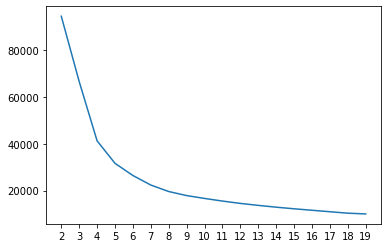

In [5]:
import itertools

numpy_arr = testing_df.values[:, 1:]
k_values = list(range(2, 20))
losses = []
saved = None
for k in k_values:
  km = KMeans(n_clusters = k)
  km.fit(numpy_arr)
  if k == 4:
    saved = km
  distances = km.fit_transform(numpy_arr)
  losses.append(np.mean(np.min(distances, axis=1)**2))
plt.plot([str(d) for d in k_values], losses)
plt.show()

# KMeans Cluster Graphs

[1 1 0 ... 0 1 1]


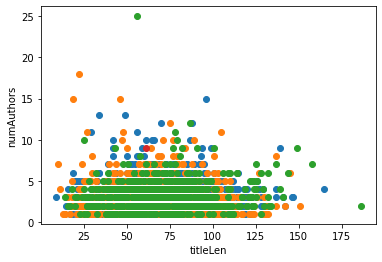

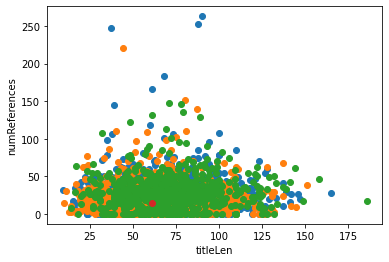

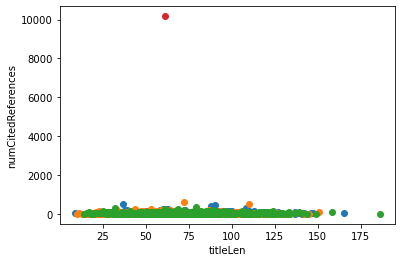

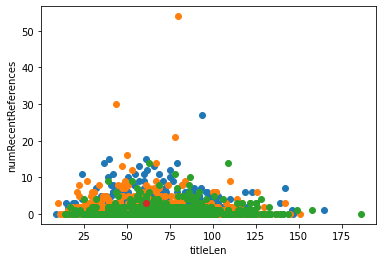

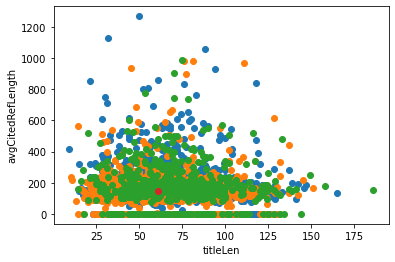

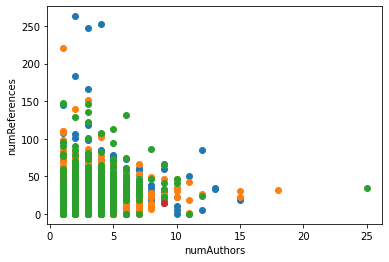

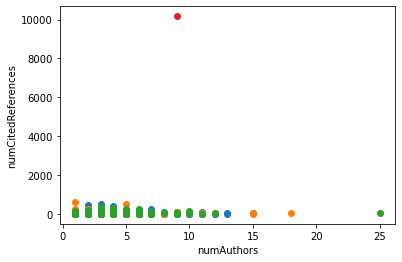

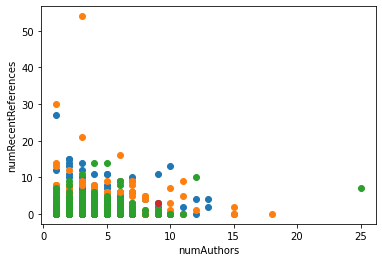

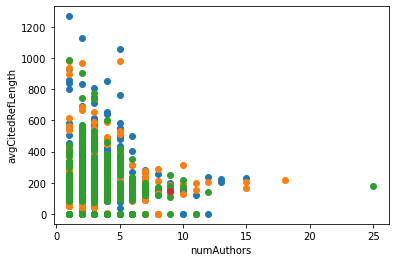

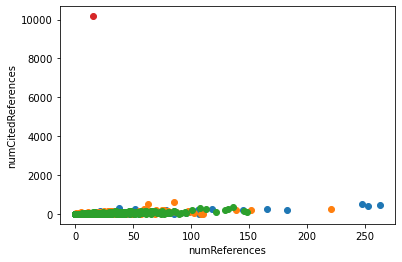

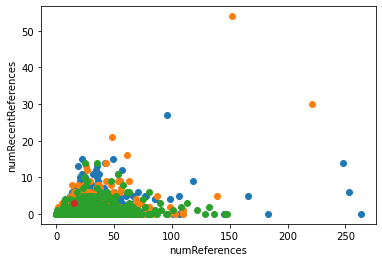

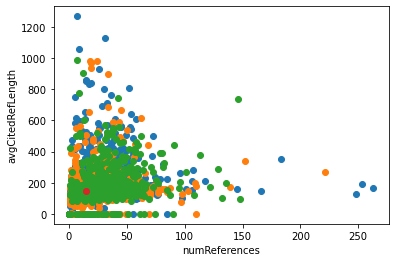

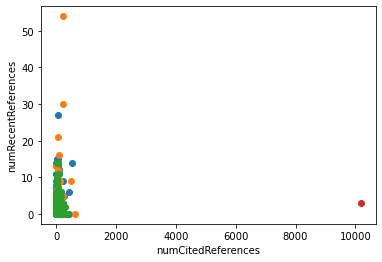

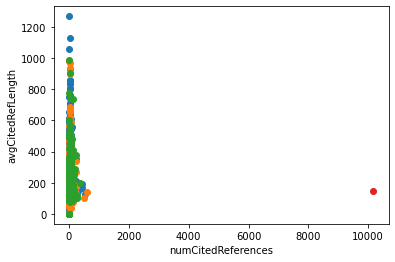

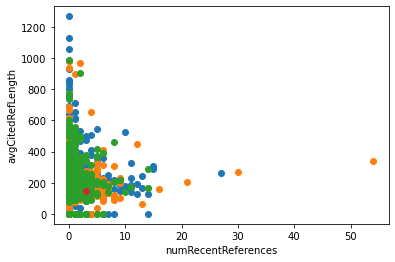

In [6]:
features = ['titleLen',	'numAuthors',	'numReferences',	'numCitedReferences',	'numRecentReferences',	'avgCitedRefLength']
print(saved.labels_)
# print(np.argwhere(np.array(saved.labels_) == 1))
for (index1, feature1), (index2, feature2) in itertools.combinations(enumerate(features), 2):
  for i in range(5):
    data_points = np.squeeze(np.argwhere(np.array(saved.labels_) == i))
    matching_coords = []
    if len(numpy_arr[data_points, :].shape) == 2:
      matching_coords = numpy_arr[data_points, :][:, [index1, index2]]
    else:
      matching_coords = np.array([[numpy_arr[data_points, :][index1], numpy_arr[data_points, :][index2]]])
    plt.scatter(matching_coords[:, 0], matching_coords[:, 1])
  plt.xlabel(feature1)
  plt.ylabel(feature2)
  plt.show()
      
